In [28]:
import os
from pathlib import Path
from typing import Iterable, Optional

import hydra
import numpy as np
import torch
import wandb
from accelerate import Accelerator
from matplotlib.cm import get_cmap
from omegaconf import DictConfig, OmegaConf
from PIL import Image
from skimage.color import label2rgb
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import importlib

In [29]:
# evaluation utilities
import eval_utils
# for reading a dataset with groundth truth and labels
from dataset import EvalDataset


name="mutinfo_val_car_TEST"
dataset_dir="/home/guests/oleksandra_tmenova/test/project/thesis-codebase/data/mutinfo_val_car_TEST"
n_classes=2
n_clusters=15
gt_dir=""
pred_dir=""
thresh=0.0


In [30]:
dataset = EvalDataset(dataset_dir,gt_dir, pred_dir)

root: /home/guests/oleksandra_tmenova/test/project/thesis-codebase/data/mutinfo_val_car_TEST
image_dir: /home/guests/oleksandra_tmenova/test/project/thesis-codebase/data/mutinfo_val_car_TEST/images
gt_dir: /home/guests/oleksandra_tmenova/test/project/thesis-codebase/data/mutinfo_val_car_TEST/ground_truth
pred_dir: /home/guests/oleksandra_tmenova/test/project/thesis-codebase/data/mutinfo_val_car_TEST/predictions
Checking sizes of ground truth and predictions


100%|██████████| 5/5 [00:00<00:00, 192.86it/s]


In [31]:
# Iterate
tp = [0] * n_classes
fp = [0] * n_classes
fn = [0] * n_classes

matches = []
iou_matrices = []
remapped_preds = []

In [32]:
image, gt, pred, metadata = dataset[1]

In [33]:
print(metadata['id'])

ultrasonix_test364


In [34]:
image_list = image.tolist()
print(image_list)

[[[25, 25, 25], [27, 27, 27], [30, 30, 30], [34, 34, 34], [38, 38, 38], [41, 41, 41], [41, 41, 41], [41, 41, 41], [37, 37, 37], [36, 36, 36], [37, 37, 37], [38, 38, 38], [40, 40, 40], [41, 41, 41], [39, 39, 39], [37, 37, 37], [36, 36, 36], [36, 36, 36], [34, 34, 34], [33, 33, 33], [31, 31, 31], [32, 32, 32], [35, 35, 35], [38, 38, 38], [41, 41, 41], [45, 45, 45], [47, 47, 47], [44, 44, 44], [41, 41, 41], [39, 39, 39], [38, 38, 38], [35, 35, 35], [35, 35, 35], [32, 32, 32], [31, 31, 31], [33, 33, 33], [36, 36, 36], [38, 38, 38], [39, 39, 39], [40, 40, 40], [41, 41, 41], [42, 42, 42], [41, 41, 41], [40, 40, 40], [41, 41, 41], [43, 43, 43], [43, 43, 43], [42, 42, 42], [40, 40, 40], [38, 38, 38], [35, 35, 35], [33, 33, 33], [31, 31, 31], [29, 29, 29], [27, 27, 27], [24, 24, 24], [26, 26, 26], [24, 24, 24], [20, 20, 20], [16, 16, 16], [12, 12, 12], [7, 7, 7], [8, 8, 8], [15, 15, 15], [16, 16, 16], [17, 17, 17], [19, 19, 19], [20, 20, 20], [19, 19, 19], [17, 17, 17], [14, 14, 14], [12, 12, 1

(-0.5, 389.5, 329.5, -0.5)

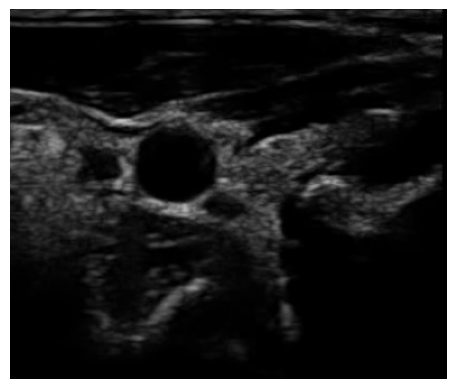

In [35]:
plt.imshow(image)
plt.axis(False)

(-0.5, 389.5, 329.5, -0.5)

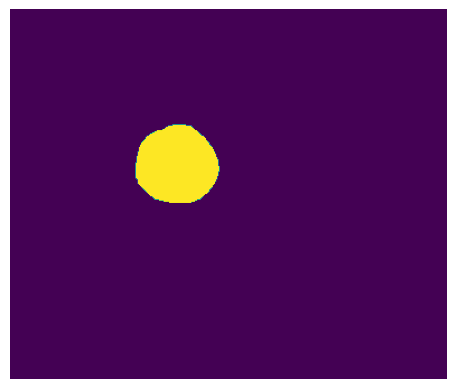

In [36]:
plt.imshow(gt)
plt.axis(False)

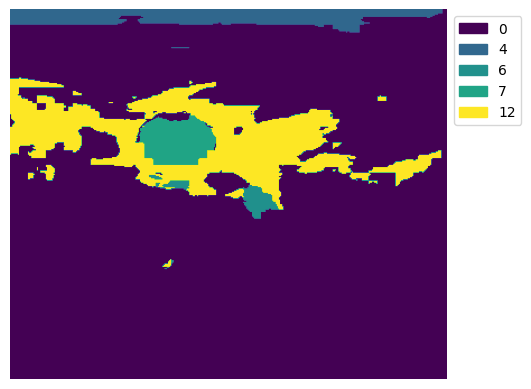

In [37]:
values = np.unique(pred.ravel())
im = plt.imshow(pred)
plt.axis(False)
colors = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label="{l}".format(l=values[i]) ) for i in range(len(values)) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1., 1), loc=2)

In [40]:
# import eval_utils
importlib.reload(eval_utils)
# import eval_utils

# Do matching 
gt_unique = np.unique(gt)
pred_unique = np.unique(pred)
print(f'GT unique labels: {gt_unique}')
print(f'PRED unique labels: {pred_unique}')
if np.array_equal(gt_unique,pred_unique) and n_clusters==n_classes:
# if len(gt_unique)==len(pred_unique):
    print('Using hungarian algorithm for matching')
    match, iou_mat  = eval_utils.hungarian_match(pred, gt, preds_k=n_clusters, targets_k=n_classes, metric='iou', thresh=thresh)
else:
    print('Using majority voting for matching')
    match, iou_mat, results = eval_utils.majority_vote_unique(pred, gt, preds_k=n_clusters, targets_k=n_classes, thresh=thresh)
print(f'Optimal matching: {match}')

GT unique labels: [0 1]
PRED unique labels: [ 0  4  6  7 12]
Using majority voting for matching
No threshold used
Optimal matching: [(0, 0), (7, 1)]


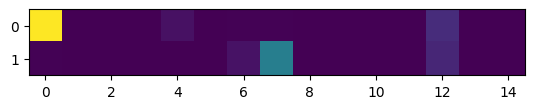

In [41]:
plt.imshow(iou_mat)

In [42]:
iou_mat.shape

(2, 15)

In [43]:
for gt in range(iou_mat.shape[0]):
    for pl in range(iou_mat.shape[1]):
        print(f'PL {pl}, GT {gt}: IoU value={iou_mat[gt][pl]}') 

PL 0, GT 0: IoU value=0.8399335717935615
PL 1, GT 0: IoU value=0.0
PL 2, GT 0: IoU value=0.0
PL 3, GT 0: IoU value=0.0
PL 4, GT 0: IoU value=0.03910614525139665
PL 5, GT 0: IoU value=0.0
PL 6, GT 0: IoU value=0.004552376372525447
PL 7, GT 0: IoU value=0.005067781578613962
PL 8, GT 0: IoU value=0.0
PL 9, GT 0: IoU value=0.0
PL 10, GT 0: IoU value=0.0
PL 11, GT 0: IoU value=0.0
PL 12, GT 0: IoU value=0.10546509599987317
PL 13, GT 0: IoU value=0.0
PL 14, GT 0: IoU value=0.0
PL 0, GT 1: IoU value=0.006074133704123824
PL 1, GT 1: IoU value=0.0
PL 2, GT 1: IoU value=0.0
PL 3, GT 1: IoU value=0.0
PL 4, GT 1: IoU value=0.0
PL 5, GT 1: IoU value=0.0
PL 6, GT 1: IoU value=0.039709649871904354
PL 7, GT 1: IoU value=0.3582842724978974
PL 8, GT 1: IoU value=0.0
PL 9, GT 1: IoU value=0.0
PL 10, GT 1: IoU value=0.0
PL 11, GT 1: IoU value=0.0
PL 12, GT 1: IoU value=0.0896670493685419
PL 13, GT 1: IoU value=0.0
PL 14, GT 1: IoU value=0.0


In [44]:
results

array([0, 7])

In [45]:
match

[(0, 0), (7, 1)]